# EPA1361 - Model-Based Decision Making

## Multi-model analysis

This exercise uses a simple version of the [Lotka-Volterra predator-prey equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) to show how the EMA Workbench can be used for a
multi-model analysis, in addition to typical parametric/structural uncertainties. This will let you test the connectors provided in the Workbench for Excel, NetLogo, and Vensim / PySD; we'll also use the models for the sensitivity analysis exercise in week 3.

* Using the three model files provided and the Python function below, define model objects for each implementation (Excel, NetLogo, Vensim/PySD, and Python), and test them using a single ensemble. Use 50 experiments sampled from the parameters below (so that each experiment will be executed for the 4 models, for a total of 200), and retrieve outputs for the _TIME_, _predators_, and _prey_ variables.
    * excel and vensim are only supported on windows
    * vensim requires 32 bit python, and a 7.1!! version of vensim DSS
    * Netlogo supoprt depends on [jpype](http://jpype.readthedocs.io/en/latest/install.html) and [pynetlogo](https://pynetlogo.readthedocs.io/en/latest/). Also, if you don't have NetLogo installed, please get it from [NetLogo 6.0](https://ccl.northwestern.edu/netlogo/download.shtml) 
    * for pysd, see [its documentation](http://pysd.readthedocs.io/en/master/installation.html)
    * If possible try to work with all model versions, but even 2 or 3 (pure python and something else should be sufficient).
    

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |
|Final time	    |365	    |
|dt	    |0.25	    |

* Note that your EMA Workbench installation includes example scripts for the different connectors. The different model objects follow a similar syntax but will need to be slightly adjusted depending on the software (e.g. to specify the NetLogo run length or the sheet name in Excel). 

* These model objects can be used with a replication functionality (for instance to test the effect of stochastic uncertainty in a NetLogo model), which repeats a given experiment over multiple replications. You can use a single replication in this exercise as the models are not stochastic. By default, each outcome array will then have a shape of (# experiments, # replications, # time steps). Try adapting the outcome arrays so that they can be used with the _lines_ plotting function of the Workbench, and plot the results grouped by model.

* To check the graphical results, find the maximum absolute error of the time series you obtained for the _prey_ variable in the Excel, NetLogo, and Vensim/PySD models, relative to the Python function. 

import sys
!{sys.executable} -m pip install SALib
!{sys.executable} -m pip install platypus-opt
!{sys.executable} -m pip install pydot 

import sys
!{sys.executable} -m pip install pyNetLogo
!{sys.executable} -m pip install jpype1 
!{sys.executable} -m pip install pysd

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging, SequentialEvaluator, MultiprocessingEvaluator)

In [2]:
def three_to_two_dimensions(outcome):
    d=dict()
    for i in outcome:
        a=[]
        for j in outcome[i]:
             a.append(j[0])
        d.update({i : np.array(a)})
    return d

In [3]:
def PredPrey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, final_time=365, reps=1):

    #Initial values
    predators, prey, sim_time = [np.zeros((reps, int(final_time/dt)+1)) for _ in range(3)]
    
    for r in range(reps):
        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

        #Calculate the time series
        for t in range(0, sim_time.shape[1]-1):

            dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
            dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

            prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
            predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
            sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,'predators':predators,'prey':prey}

In [4]:
uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                 RealParameter('predation_rate', 0.0005, 0.003),
                 RealParameter('predator_efficiency', 0.001, 0.004)]

outcomes = [TimeSeriesOutcome('predators'),
            TimeSeriesOutcome('prey')]

__Python__

In [5]:
if __name__ == "__main__":
    ema_logging.log_to_stderr(level=ema_logging.INFO)
    
    Python = Model('PredPreyPython', function=PredPrey)

    Python.uncertainties = uncertainties

    Python.outcomes = outcomes

__Vensim__

In [6]:
from ema_workbench.connectors.pysd_connector import PysdModel

if __name__ == "__main__":
    ema_logging.log_to_stderr(level=ema_logging.INFO)
    
    Vensim = PysdModel(mdl_file='./model/PredPrey.mdl')
    
    Vensim.uncertainties = uncertainties

    Vensim.outcomes = outcomes

[MainProcess/INFO] using 64 bit vensim


__Excel__

In [7]:
from ema_workbench.connectors.excel import ExcelModel

if __name__ == "__main__":
    ema_logging.log_to_stderr(level=ema_logging.INFO)
    
    Excel = ExcelModel("PredPreyExcel", wd="./model", model_file='PredPrey.xlsx')
    
    Excel.uncertainties = uncertainties

    Excel.outcomes = outcomes

    Excel.default_sheet = "Sheet1"

__Netlogo__

In [8]:
from __future__ import unicode_literals, absolute_import
from ema_workbench.connectors.netlogo import NetLogoModel

if __name__ == '__main__':
    ema_logging.log_to_stderr(level=ema_logging.INFO)

    NetLogo = NetLogoModel('PredPreyNetlogo', wd="./model", model_file="PredPrey.nlogo")
    
    NetLogo.run_length = 365*4
    NetLogo.replications = 1

    NetLogo.uncertainties = uncertainties

    NetLogo.outcomes = outcomes

__Run Experiments__

In [9]:
with SequentialEvaluator((Python, Vensim, Excel, NetLogo)) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=50)

outcomes = three_to_two_dimensions(outcomes)

Difference=dict()
for i in outcomes:
    a=[]
    for j in range(200):
        a.append(np.subtract(list(outcomes[i])[j],list(outcomes[i])[j%50]))
    Difference.update({i : np.array(a)})

[MainProcess/INFO] performing 50 scenarios * 1 policies * 4 model(s) = 200 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 140 cases completed
[MainProcess/INFO] 160 cases completed
[MainProcess/INFO] 180 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] experiments finished


__Plot Outcomes of experiments grouped by model__

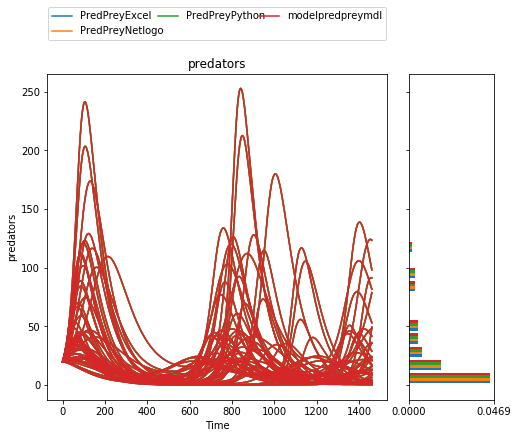

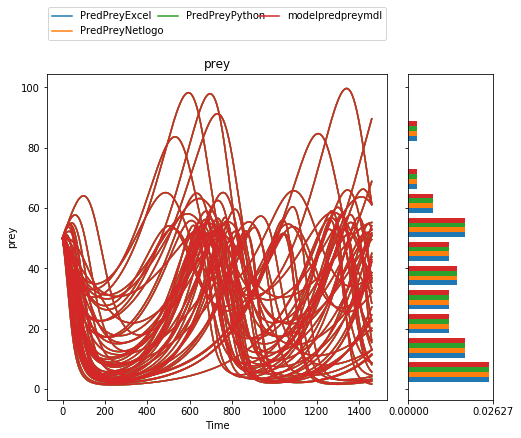

In [10]:
from ema_workbench.analysis import plotting, plotting_util
from ema_workbench.analysis.plotting import lines, Density


for outcome in outcomes.keys():
    fig, axis = plotting.lines(experiments, outcomes, outcomes_to_show=outcome, density=plotting_util.Density.HIST,group_by='model')
    fig.set_size_inches(8,6)
plt.show()

__Plot Differences with python model grouped by model__

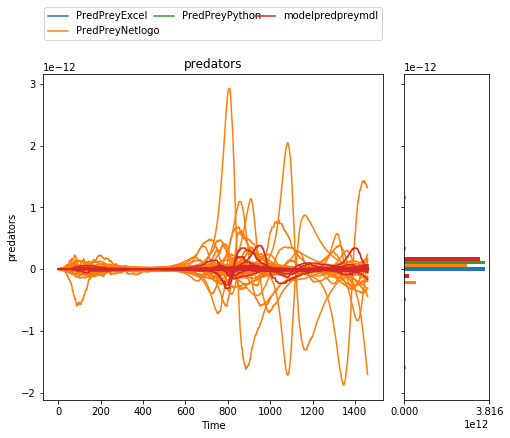

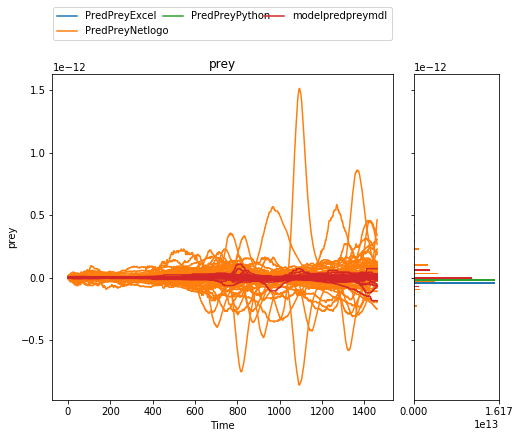

In [11]:
from ema_workbench.analysis import plotting, plotting_util
from ema_workbench.analysis.plotting import lines, Density


for outcome in outcomes.keys():
    fig, axis = plotting.lines(experiments, Difference, outcomes_to_show=outcome, density=plotting_util.Density.HIST,group_by='model')
    fig.set_size_inches(8,6)
plt.show()

In [12]:
pythonmax= abs(Difference['prey']).max(axis=1)[0:50].max()
print('python: ',pythonmax)
Vensimmax = abs(Difference['prey']).max(axis=1)[50:100].max()
print('vensim: ',Vensimmax)
Excelmax = abs(Difference['prey']).max(axis=1)[100:150].max()
print('excel: ',Excelmax)
Netlogomax = abs(Difference['prey']).max(axis=1)[150:200].max()
print('netlogo: ',Netlogomax)



python:  0.0
vensim:  1.8474111129762605e-13
excel:  0.0
netlogo:  1.5134560271690134e-12
